# Transient Analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Charging RC Circuit

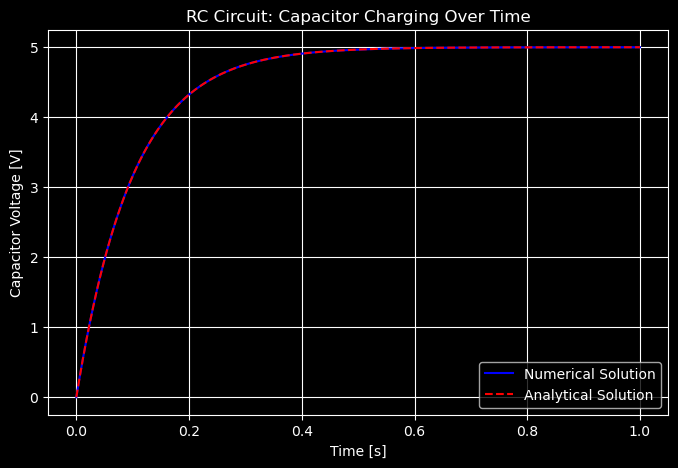

In [7]:
# --- Parameters ---
R = 1e3       # resistance in ohms
C = 100e-6    # capacitance in farads
Vs = 5        # supply voltage in volts

# --- Differential equation: dVc/dt = (Vs - Vc) / (R*C) ---
def dVcdt(t, Vc):
    return (Vs - Vc) / (R * C)

# --- Time range and initial condition ---
t_span = (0, 1)           # simulate for 1 second
Vc0 = [0]                 # initial voltage (capacitor initially uncharged)
t_eval = np.linspace(*t_span, 500)

# --- Solve ODE ---
solution = solve_ivp(dVcdt, t_span, Vc0, t_eval=t_eval)

# --- Analytical solution for comparison ---
Vc_analytical = Vs * (1 - np.exp(-solution.t / (R * C)))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(solution.t, solution.y[0], 'b', label='Numerical Solution')
plt.plot(solution.t, Vc_analytical, 'r--', label='Analytical Solution')
plt.title('RC Circuit: Capacitor Charging Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Capacitor Voltage [V]')
plt.grid(True)
plt.legend()
plt.show()
